# Use Regression to define weights for each feature

In [25]:
from os import listdir,remove
import numpy as np
from syntax_features import counts
from tqdm import tqdm
import codecs
import pandas as pd

from sklearn.preprocessing import normalize
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from itertools import combinations
import matplotlib.pyplot as plt
from collections import Counter

import _pickle as pickle

from feature_extraction import TextFeatureCreator


In [2]:
import multiprocessing
cores = multiprocessing.cpu_count()
cores

8

In [3]:
ts = TextFeatureCreator("data/LSATtexts.txt")

## Load Data and define Features

In [32]:
#def normalize_cols(df,norm_cols):
#    df[norm_cols] = (df[norm_cols]-df[norm_cols].min())/(df[norm_cols].max()-df[norm_cols].min())
#    return df

In [4]:
def score_file_text(file_path):
    with codecs.open(file_path, "r",encoding='utf-8', errors='ignore') as f:
        score = ts.norm_features(ts.get_text_features([f.read()]))
        #score[12] = 1 / score[12]
    return score

### Training Newsela

In [28]:
#delete spanish texts
newsela_path = "data/newsela/"
files = [file for file in listdir(newsela_path) if file[-3:] == "txt"]
spanish_files = [file for file in files if file[:-4].split("-")[-3] == "spanish"]
for file in spanish_files:
    remove(newsela_path+"/"+file)

In [29]:
files_with_score = []
for file in files:
    split_file_name = file[:-4].split("-")
    file_name = "-".join(split_file_name[:-2])
    file_id = split_file_name[-2]
    level = split_file_name[-1]
    files_with_score += [(newsela_path+file,file_name,file_id,level)]
files_with_score[:5]

[('data/newsela/nano-silver-2940-1030.txt', 'nano-silver', '2940', '1030'),
 ('data/newsela/elem-robot-dog-funeral-japan-42851-970.txt',
  'elem-robot-dog-funeral-japan',
  '42851',
  '970'),
 ('data/newsela/public-schools-confederate-names-34585-830.txt',
  'public-schools-confederate-names',
  '34585',
  '830'),
 ('data/newsela/food-waste-6332-490.txt', 'food-waste', '6332', '490'),
 ('data/newsela/scotus-jerusalem-10579-720.txt',
  'scotus-jerusalem',
  '10579',
  '720')]

In [ ]:
lines = []

for path,article_name,file_id,newsela_score in tqdm(files_with_score):
    score = score_file_text(path)
    lines += [np.concatenate([[path,article_name,file_id,newsela_score],score.reshape(-1)])]


  2%|▏         | 534/21501 [01:20<52:29,  6.66it/s] 

In [31]:
df = pd.DataFrame(
    data=lines,
    columns=np.concatenate([["path","name","text","newsela_score"],ts.feature_names]))
df[df.columns[2:]] = df[df.columns[2:]].astype(float)
df.head()

[array(['data/newsela/nano-silver-2940-1030.txt', 'nano-silver', '2940',
        '1030', '1.0170966329174458', '0.5857396435628679',
        '0.8624512080423764', '0.5813385390660711', '0.9231200061348681',
        '0.6805668647867997', '0.8164323039739796', '0.5365369862820538',
        '0.5692894326953637', '0.5273946023550725', '0.33320942173511514',
        '0.377545723323338', '1.1412492521944704', '0.4622148377925172',
        '0.3766541562339471', '0.9164337172599898', '0.0',
        '0.8005818991614121', '0.6114497257073462', '0.3692074659262521',
        '0.5167583892591907'],
       dtype='<U38'),
 array(['data/newsela/elem-robot-dog-funeral-japan-42851-970.txt',
        'elem-robot-dog-funeral-japan', '42851', '970',
        '0.9154731640767939', '0.5426345924514248', '0.8997044057016063',
        '0.5088720409173505', '0.9203124100295567', '0.5990728004462701',
        '0.5906106028747937', '0.4612448010208619', '0.24881178219753045',
        '0.7143227359349972', '0.411194

### Exclude Spanish Texts

In [115]:
df = df[~df["name"].str.contains("spanish")]

In [117]:
df.to_csv("data/newsela_full_scores.csv",index=False,sep=";")

In [55]:
article_df = pd.read_csv("data/newsela_articles.csv",sep=";")
article_df = article_df[~article_df["title"].str.contains("spanish")]
article_df.to_csv("data/newsela_articles.csv",sep=";",index=False)

### Add ElSAT Text to file

In [141]:
copy_df = pd.DataFrame(data=[np.concatenate([["LSAT","0000",1800],len(feature_cols)*[1.0]])],columns=df.columns)
df = df.loc[df["name"] != "LSAT"]
df = pd.concat([df,copy_df])

In [143]:
df[feature_cols] = df[feature_cols].astype(float)
df.dtypes

name                       object
text                       object
newsela_score              object
Subordination             float64
Complements               float64
Coordination              float64
Apposition                float64
Passive verbs             float64
Parataxis                 float64
Auxiliary Verbs           float64
Negation                  float64
Prepositional Phrases     float64
Modifiers                 float64
Mean word length          float64
Mean sentence length      float64
Basic english ratio       float64
Syllables per sentence    float64
Type token ratio          float64
#nouns                    float64
#verbs                    float64
#adjectives               float64
#adverbs                  float64
#pronouns                 float64
#commas                   float64
dtype: object

### Training Weebit

In [288]:
weebit_root = "data/weebit/WeeBit-TextOnly/"
weebit_folders = listdir(weebit_root)
weebit_folders.remove(".DS_Store")
weebit_data = []
for folder in weebit_folders:
    curr_path = weebit_root + folder
    weebit_data += [
        np.concatenate([
            [curr_path,file_name],
            score_file_text(curr_path+"/"+file_name)]) 
        for file_name in listdir(curr_path)]


/Users/d062280/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  after removing the cwd from sys.path.


In [298]:
weebit_df = pd.DataFrame(
    data=weebit_data,
    columns=np.concatenate([["path","id"],re_feature_names,pa_feature_names]))
for col in feature_cols:
    weebit_df[col] = pd.to_numeric(weebit_df[col])
weebit_df.head()

,path,id,Subordination,Complements,Coordination,Apposition,Passive verbs,Parataxis,Auxiliary Verbs,Negation,...,Mean sentence length,Basic english ratio,Syllables per sentence,Type token ratio,#nouns,#verbs,#adjectives,#adverbs,#pronouns,#commas
0,data/weebit/WeeBit-TextOnly/BitGCSE,3644.txt,0.416388,1.529274,0.104271,1.869321,0.359071,0.000000,0.809367,2.844940,...,0.542543,0.295664,0.487939,2.986359,0.588615,0.733500,0.422830,0.641723,0.831464,0.061097
1,data/weebit/WeeBit-TextOnly/BitGCSE,5235.txt,0.312291,1.019516,0.469218,0.934660,0.718141,0.000000,0.625420,0.853482,...,0.671807,0.352659,0.652619,2.572531,0.782239,0.563223,0.570820,0.521400,0.226763,0.519322
2,data/weebit/WeeBit-TextOnly/BitGCSE,1053.txt,0.255511,0.695125,0.682499,3.058888,0.293785,5.405217,0.481607,0.931071,...,0.632482,0.388578,0.603825,3.253361,0.878276,0.612996,0.646930,0.505357,0.340144,0.329922
3,data/weebit/WeeBit-TextOnly/BitGCSE,7422.txt,0.437207,0.917564,0.312812,1.121592,1.292654,0.000000,0.794652,0.682786,...,0.578955,0.328614,0.557715,2.425400,0.622693,0.612996,0.887943,0.336905,0.498878,0.183290
4,data/weebit/WeeBit-TextOnly/BitGCSE,7344.txt,0.936873,0.983105,0.469218,1.201706,1.615817,0.000000,0.898713,1.097334,...,0.706919,0.345606,0.694791,2.619382,0.896200,0.909390,0.570820,0.464103,0.388736,0.235659


In [300]:
#Remove metadata files
weebit_df = weebit_df.loc[weebit_df["id"] != ".DS_Store"]
#Remove Inf value rows
weebit_df = weebit_df.loc[np.isfinite(weebit_df["Basic english ratio"])]

In [301]:
weebit_df.to_csv("data/weebit_features.csv",index=False,sep=";")

## Plot Result

In [144]:
plot_df = df.loc[df["newsela_score"] != "max"]
plot_df["newsela_score"] = pd.to_numeric(plot_df["newsela_score"])

In [145]:
#normalize features
norm_df = plot_df.copy()
#newsela_scores = norm_df["newsela_score"]
#norm_df = normalize_cols(norm_df,["newsela_score"])#norm_df[norm_cols] = normalize(plot_df[norm_cols])#(norm_df[norm_cols] - norm_df[norm_cols].mean())/norm_df[norm_cols].std()
norm_df["newsela_score"] = norm_df["newsela_score"] / norm_df["newsela_score"].max()
norm_df.head()

,name,text,newsela_score,Subordination,Complements,Coordination,Apposition,Passive verbs,Parataxis,Auxiliary Verbs,...,Mean sentence length,Basic english ratio,Syllables per sentence,Type token ratio,#nouns,#verbs,#adjectives,#adverbs,#pronouns,#commas
1,elem-robot-dog-funeral-japan,42851,0.538889,0.458876,0.686613,0.248973,1.545051,0.329759,0.0,0.405435,...,0.552227,0.449709,0.525573,2.228583,0.619925,0.596944,0.501998,0.261127,0.651340,0.409478
4,public-schools-confederate-names,34585,0.461111,0.194675,0.675264,0.280312,1.092460,0.377724,0.0,0.430006,...,0.461136,0.472796,0.433186,2.047905,0.673146,0.532162,0.222892,0.268149,0.330426,0.274935
5,food-waste,6332,0.272222,0.141415,0.779064,0.123944,0.000000,0.121948,0.0,0.374836,...,0.348778,0.330957,0.276557,2.223179,0.394992,0.488376,0.199334,0.343780,0.534512,0.144014
7,scotus-jerusalem,10579,0.400000,0.279418,0.858540,0.148174,0.442734,0.396867,0.0,0.557650,...,0.421927,0.359013,0.369745,1.686886,0.557635,0.538898,0.135910,0.348078,0.413032,0.157106
8,starwars-rey,14159,0.594444,0.538702,1.185187,0.328453,1.892687,0.242373,0.0,0.612544,...,0.643587,0.473433,0.579428,2.258754,0.851943,0.753147,0.380547,0.501346,0.434629,0.320758


In [146]:
norm_df.loc[norm_df["newsela_score"] == 1.0]

,name,text,newsela_score,Subordination,Complements,Coordination,Apposition,Passive verbs,Parataxis,Auxiliary Verbs,...,Mean sentence length,Basic english ratio,Syllables per sentence,Type token ratio,#nouns,#verbs,#adjectives,#adverbs,#pronouns,#commas
0,LSAT,0000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [147]:
norm_df["feature_sums"] = norm_df[feature_cols].sum(axis=1)
norm_df["feature_sums"] = pd.to_numeric(norm_df["feature_sums"].values)


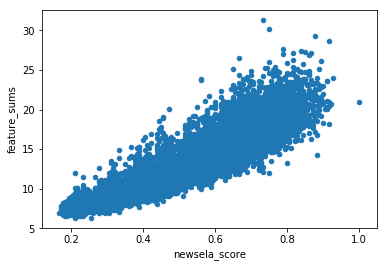

In [148]:
norm_df.plot.scatter(x="newsela_score",y="feature_sums")

In [162]:
norm_df.to_csv("data/newsela_article_features.csv",sep=";",index=False)

In [157]:
norm_df.loc[norm_df["feature_sums"] > 30]

,name,text,newsela_score,Subordination,Complements,Coordination,Apposition,Passive verbs,Parataxis,Auxiliary Verbs,...,Basic english ratio,Syllables per sentence,Type token ratio,#nouns,#verbs,#adjectives,#adverbs,#pronouns,#commas,feature_sums
1790,dog-brain-scan,21214,0.733333,0.847647,1.820564,0.938436,0.400569,0.923324,11.325217,0.819879,...,0.375860,0.893314,2.279914,0.873140,1.141613,0.721036,1.595865,1.396382,0.926098,31.261766
25752,california-secession,29511,0.750000,1.176074,1.008670,0.698835,2.863640,0.137516,10.120407,0.929912,...,0.485467,0.876461,2.192296,0.946819,0.982366,0.737310,0.827222,0.680288,0.973729,30.207983


In [161]:
ts.re_features_max[5]*11

0.18500643492889732

## Apply Regression Model

* LogisticRegression
* LassoCV
* RidgeCV

In [191]:
norm_df = pd.read_csv("data/newsela_article_features.csv",sep=";")
norm_df["newsela_score"] = norm_df["newsela_score"].astype(float)

In [16]:
feature_cols = norm_df.columns[2:-1]

In [282]:
def train_eval_model(train,test,model_fn):
    model = model_fn()
    
    model.fit(train[feature_cols],train["newsela_score"])
    
    print("Evaluation: \n Feature Importance:")
        
    for row in zip(*[train.columns,model.coef_]):
        print(row)
    print("Train Accuracy: ")
    print(model.score(train[feature_cols],
                    train["newsela_score"]))
    print("Test Accuracy: ")
    print(model.score(test[feature_cols],
                    test["newsela_score"]))
    
    return model

In [279]:
def eval_exclude_cols(df,feature_cols,exclude,test,model_fn):
    col_without = feature_cols
    bool_without = [col not in exclude for col in col_without]
    col_without = col_without[bool_without]
    #print(col_without,bool_without)
    train = df[["newsela_score"] + list(col_without)]
    
    return train_eval_model(
        train,test,model_fn)

In [237]:
y_bins = np.digitize(norm_df["newsela_score"], np.linspace(0,1,50))
y_bins[-1] = np.sort(y_bins)[-2]

In [273]:
#Test and Training Set
train,test = train_test_split(
    norm_df[["newsela_score"] + list(feature_cols)],
    stratify=y_bins,
    test_size=0.2)

R2 Coefficient: 0.9446726379407067


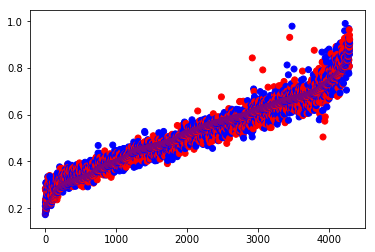

In [274]:
test_sorted = test.sort_values("newsela_score")
model = linear_model.RidgeCV()
model.fit(train[feature_cols],train["newsela_score"])
predictions = model.predict(test_sorted[feature_cols])
plt.scatter(
    x=[range(len(test)),range(len(test))],
    y=[predictions,test_sorted["newsela_score"]],
    c=["blue","red"])

print(f"R2 Coefficient: {model.score(test[feature_cols],test['newsela_score'])}")

In [276]:
model.predict(norm_df.loc[norm_df["name"] == "dog-brain-scan"][feature_cols])*1800

array([ 1472.88908448,   629.12380774,   861.55721319,   939.00420908,
        1164.1528141 ])

In [277]:
norm_df.loc[norm_df["name"] == "dog-brain-scan"]["newsela_score"]*1800

1440     1320.0
2239      550.0
9818      860.0
14526     980.0
18210    1170.0
Name: newsela_score, dtype: float64

### All Attributes

In [176]:
norm_df.head()

,name,text,newsela_score,Subordination,Complements,Coordination,Apposition,Passive verbs,Parataxis,Auxiliary Verbs,...,Basic english ratio,Syllables per sentence,Type token ratio,#nouns,#verbs,#adjectives,#adverbs,#pronouns,#commas,feature_sums
0,elem-robot-dog-funeral-japan,42851,0.538889,0.458876,0.686613,0.248973,1.545051,0.329759,0.0,0.405435,...,0.449709,0.525573,2.228583,0.619925,0.596944,0.501998,0.261127,0.651340,0.409478,12.912367
1,public-schools-confederate-names,34585,0.461111,0.194675,0.675264,0.280312,1.092460,0.377724,0.0,0.430006,...,0.472796,0.433186,2.047905,0.673146,0.532162,0.222892,0.268149,0.330426,0.274935,10.793261
2,food-waste,6332,0.272222,0.141415,0.779064,0.123944,0.000000,0.121948,0.0,0.374836,...,0.330957,0.276557,2.223179,0.394992,0.488376,0.199334,0.343780,0.534512,0.144014,8.900145
3,scotus-jerusalem,10579,0.400000,0.279418,0.858540,0.148174,0.442734,0.396867,0.0,0.557650,...,0.359013,0.369745,1.686886,0.557635,0.538898,0.135910,0.348078,0.413032,0.157106,9.790550
4,starwars-rey,14159,0.594444,0.538702,1.185187,0.328453,1.892687,0.242373,0.0,0.612544,...,0.473433,0.579428,2.258754,0.851943,0.753147,0.380547,0.501346,0.434629,0.320758,14.472478


In [308]:
#RidgeCV
model = eval_exclude_cols(
    train,
    feature_cols,
    [],
    test,
    linear_model.RidgeCV
)

Evaluation: 
 Feature Importance:
('newsela_score', 0.060500391393874864)
('Subordination', 0.018673299997580273)
('Complements', 0.051781941187977409)
('Coordination', -0.0049539247233489903)
('Apposition', -0.0026065849771170768)
('Passive verbs', 5.9643348500060256e-06)
('Parataxis', 0.039649780483874686)
('Auxiliary Verbs', -0.0022626084957320103)
('Negation', 0.082440494857648261)
('Prepositional Phrases', 0.061453234654275768)
('Modifiers', 0.58315022277822059)
('Mean word length', 0.83293800467433154)
('Mean sentence length', 0.22767137277292449)
('Basic english ratio', -0.62614019975906565)
('Syllables per sentence', -0.0026612194236905751)
('Type token ratio', 0.088766707409054568)
('#nouns', 0.0045893122948212905)
('#verbs', 0.014936444614193967)
('#adjectives', 0.013373455051083116)
('#adverbs', -0.00082285866312908906)
('#pronouns', 0.053453153547433629)
Train Accuracy: 
0.945724601908
Test Accuracy: 
0.944672637941


In [375]:
len(test)

4296

### Weebit Data

In [335]:
weebit_df = pd.read_csv("data/weebit_features.csv",sep=";")

In [336]:
weebit_df["regression_score"] = model.predict(weebit_df[feature_cols])
weebit_df["feature_sums"] = weebit_df[feature_cols].sum(axis=1)

In [310]:
weebit_df

,path,id,Subordination,Complements,Coordination,Apposition,Passive verbs,Parataxis,Auxiliary Verbs,Negation,...,Syllables per sentence,Type token ratio,#nouns,#verbs,#adjectives,#adverbs,#pronouns,#commas,regression_score,feature_sum
0,data/weebit/WeeBit-TextOnly/BitGCSE,3644.txt,0.416388,1.529274,0.104271,1.869321,0.359071,0.000000,0.809367,2.844940,...,0.487939,2.986359,0.588615,0.733500,0.422830,0.641723,0.831464,0.061097,0.464173,17.221404
1,data/weebit/WeeBit-TextOnly/BitGCSE,5235.txt,0.312291,1.019516,0.469218,0.934660,0.718141,0.000000,0.625420,0.853482,...,0.652619,2.572531,0.782239,0.563223,0.570820,0.521400,0.226763,0.519322,0.586303,14.667853
2,data/weebit/WeeBit-TextOnly/BitGCSE,1053.txt,0.255511,0.695125,0.682499,3.058888,0.293785,5.405217,0.481607,0.931071,...,0.603825,3.253361,0.878276,0.612996,0.646930,0.505357,0.340144,0.329922,0.564005,22.002729
3,data/weebit/WeeBit-TextOnly/BitGCSE,7422.txt,0.437207,0.917564,0.312812,1.121592,1.292654,0.000000,0.794652,0.682786,...,0.557715,2.425400,0.622693,0.612996,0.887943,0.336905,0.498878,0.183290,0.537854,14.869670
4,data/weebit/WeeBit-TextOnly/BitGCSE,7344.txt,0.936873,0.983105,0.469218,1.201706,1.615817,0.000000,0.898713,1.097334,...,0.694791,2.619382,0.896200,0.909390,0.570820,0.464103,0.388736,0.235659,0.624101,17.251138
5,data/weebit/WeeBit-TextOnly/BitGCSE,1735.txt,0.749498,1.468103,0.638137,4.037733,1.034123,2.378296,0.874117,1.229014,...,0.625376,2.175397,0.748677,0.803357,0.577867,0.561508,0.831464,0.244387,0.590313,22.158036
6,data/weebit/WeeBit-TextOnly/BitGCSE,5553.txt,0.343520,0.815613,0.250250,0.560796,0.538606,0.000000,0.463547,0.682786,...,0.446717,2.261776,0.596093,0.560965,0.314935,0.423205,0.234582,0.246494,0.445087,11.273994
7,data/weebit/WeeBit-TextOnly/BitGCSE,4895.txt,0.440881,0.449786,0.745229,0.494820,0.095048,0.000000,0.954361,3.313518,...,0.433333,1.334995,0.451029,0.901465,0.257429,0.637005,0.620263,0.339626,0.512676,13.918960
8,data/weebit/WeeBit-TextOnly/BitGCSE,3122.txt,0.361974,0.834149,0.319921,0.764722,0.146892,0.000000,0.692310,1.629375,...,0.392678,1.762946,0.538183,0.614093,0.256648,0.503678,0.648647,0.242966,0.458110,12.141971
9,data/weebit/WeeBit-TextOnly/BitGCSE,5547.txt,0.468436,2.039032,0.156406,2.803981,0.538606,0.000000,1.103683,3.413928,...,0.578208,2.901074,0.650575,0.903777,0.634245,0.721939,0.907051,0.091645,0.538963,20.755330


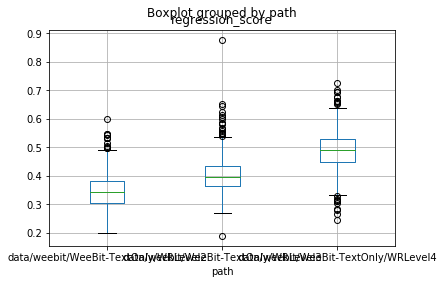

In [311]:
boxplot_data = zip(*[weebit_df["path"],weebit_df["regression_score"]])
weebit_df.loc[weebit_df["path"].str.contains("WRL")].boxplot(column="regression_score",by="path")

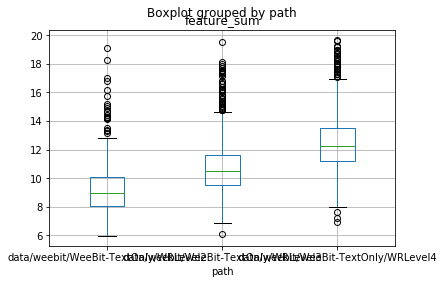

In [317]:
boxplot_data = zip(*[weebit_df["path"],weebit_df["feature_sum"]])
weebit_df.loc[
    weebit_df["path"].str.contains("WRL") &
    (weebit_df["feature_sum"] < 20)].boxplot(column="feature_sum",by="path")

## Feature Correlation

In [ ]:
#TODO: Feature Correlation each by each

### Plot Correlation Matrix

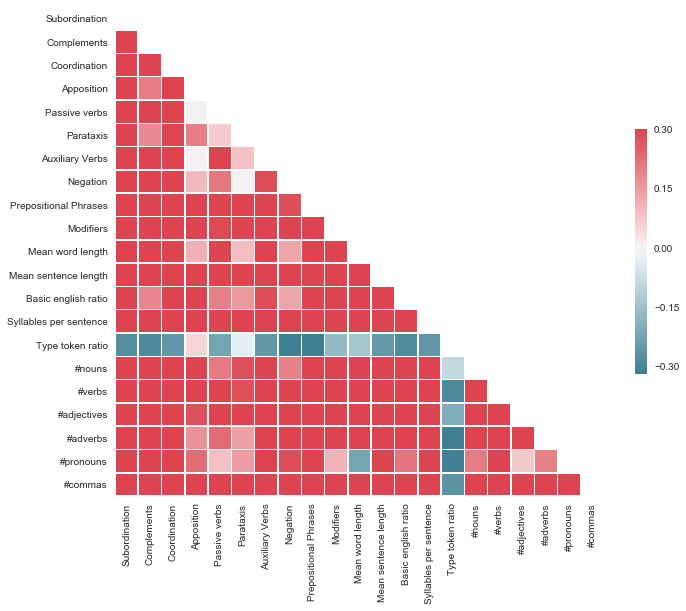

In [126]:
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white")

# Generate a large random dataset
rs = np.random.RandomState(33)
d = plot_df[plot_df.columns[2:-1]]

# Compute the correlation matrix
corr = d.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

## Save Scores for each text

In [360]:
regr_df = norm_df.copy()
regr_df["dataset"] = "newsela"
regr_df["regression_score"] = model.predict(norm_df[feature_cols])
regr_df = regr_df.rename({"name":"path"},axis=1)
#regr_df = regr_df.drop(["newsela_score"],axis=1)
regr_df["newsela_score"] = (regr_df["newsela_score"]*1800).astype(int)

In [367]:
dataset_df = weebit_df.copy()
dataset_df["dataset"] = "weebit"
dataset_df = dataset_df.rename({"id":"text"},axis=1)
#dataset_df = dataset_df.drop(["path"],axis=1)

In [368]:
dataset_df = pd.concat([regr_df,dataset_df])

In [369]:
dataset_df.to_csv("data/training_data.csv",sep=";",index=False)

In [370]:
dataset_df

,#adjectives,#adverbs,#commas,#nouns,#pronouns,#verbs,Apposition,Auxiliary Verbs,Basic english ratio,Complements,...,Prepositional Phrases,Subordination,Syllables per sentence,Type token ratio,dataset,feature_sums,newsela_score,path,regression_score,text
0,0.501998,0.261127,0.409478,0.619925,0.651340,0.596944,1.545051,0.405435,0.449709,0.686613,...,0.450745,0.458876,0.525573,2.228583,newsela,12.912367,970.0,elem-robot-dog-funeral-japan,0.494248,42851
1,0.222892,0.268149,0.274935,0.673146,0.330426,0.532162,1.092460,0.430006,0.472796,0.675264,...,0.294487,0.194675,0.433186,2.047905,newsela,10.793261,830.0,public-schools-confederate-names,0.472605,34585
2,0.199334,0.343780,0.144014,0.394992,0.534512,0.488376,0.000000,0.374836,0.330957,0.779064,...,0.122240,0.141415,0.276557,2.223179,newsela,8.900145,489.0,food-waste,0.282617,6332
3,0.135910,0.348078,0.157106,0.557635,0.413032,0.538898,0.442734,0.557650,0.359013,0.858540,...,0.309986,0.279418,0.369745,1.686886,newsela,9.790550,720.0,scotus-jerusalem,0.424582,10579
4,0.380547,0.501346,0.320758,0.851943,0.434629,0.753147,1.892687,0.612544,0.473433,1.185187,...,0.427006,0.538702,0.579428,2.258754,newsela,14.472478,1070.0,starwars-rey,0.571565,14159
5,0.226709,0.261127,0.233987,0.522042,0.434227,0.491601,0.793580,0.449803,0.362455,0.663647,...,0.272261,0.194445,0.347112,2.306133,newsela,10.227058,670.0,blind-goalball,0.360453,6739
6,0.394385,0.393785,0.499882,0.732530,0.964773,0.643003,0.723608,0.327545,0.456648,0.542646,...,0.250156,0.221626,0.491843,2.163658,newsela,11.302968,790.0,soccer-club,0.465805,5718
7,0.628730,0.564996,0.609639,0.790994,0.665500,0.732930,1.223555,0.710370,0.523535,0.945369,...,0.417636,0.493987,0.656332,2.320184,newsela,16.642362,1170.0,asteroid-corral,0.618220,263
8,0.809674,0.568335,0.304184,0.869081,0.260536,0.702287,1.792709,0.477659,0.539123,0.626752,...,0.473110,0.460757,0.657317,2.170326,newsela,13.929840,1200.0,save-elephants-plan,0.612568,24304
9,0.694498,0.649745,0.659845,1.188461,0.561238,1.078638,0.290067,0.707879,0.458013,1.001938,...,0.507736,0.468436,0.880487,2.021761,newsela,17.253500,1350.0,grizzly-bears-endangered-list,0.720460,32269


In [372]:
with open("models/ridgeCV.pkl","wb") as f:
    pickle.dump(model,f)

In [373]:
with open("models/ridgeCV.pkl","rb") as f:
    loaded_model = pickle.load(f)

In [374]:
loaded_model

RidgeCV(alphas=(0.1, 1.0, 10.0), cv=None, fit_intercept=True, gcv_mode=None,
    normalize=False, scoring=None, store_cv_values=False)